## 🚀 Notebook 3.1: The real fun begin :
## Building GPT-2 Small (124M Parameters) from Scratch!**

### 🧠 What’s Inside?

1. **Recap on Attention Mechanisms**: We'll briefly touch on the key components of attention that we developed in Notebook 2 (self-attention, causal attention, and multi-head attention), as they play a vital role in transformers.

2. **Introducing the Transformer Decoder Block**: 
   - This block forms the backbone of GPT models. We’ll start by building the **multi-head attention** and **feed-forward network (FFN)** that constitute each transformer layer.
   - Add **Layer Normalization** and **Residual Connections** to stabilize training and improve convergence.

3. **Stacking Transformer Layers**: 
   - GPT-2 small has **12 transformer layers** stacked sequentially. We’ll implement this to match GPT-2 small’s architecture.
   
4. **Position Embeddings**:
   - Since transformers are position-agnostic, we will add **learnable position embeddings** to encode positional information into the input tokens.

5. **Token Embeddings**:
   - A **token embedding layer** will be added to transform input tokens into dense vector representations.

6. **GPT Output Layer**: 
   - The final output layer maps the model’s representation back into the vocabulary space, predicting the next token in the sequence.

7. **Loading Pre-trained Weights from Hugging Face**:
   - Instead of training the model from scratch, we’ll **load pre-trained weights from Hugging Face** for GPT-2 small. This will allow us to leverage a well-trained model for better performance and faster results.
   
8. **Running Inference on GPT-2 Small**:
   - We’ll test the loaded model by running inference, generating text based on input prompts, and showcasing its ability to complete or generate sequences.

---

### 🛠 **Architecture Recap (GPT-2 Small):**

- **Number of Parameters**: 124 million.
- **Number of Layers**: 12 transformer decoder layers.
- **Hidden Size**: 768.
- **Number of Attention Heads**: 12.
- **Feed-Forward Size**: 3072.
- **Context Window Size**: 1024 tokens.

---

### 📚 **Goals for this Notebook:**

1. **Build the Full Transformer Block**: Assemble the multi-head attention, feed-forward network, and position embeddings to create the core architecture of GPT.

2. **Stack Layers**: Build a model with 12 stacked transformer blocks, following the GPT-2 small configuration.

3. **Load Pre-trained GPT-2 Weights**: Use Hugging Face to load pre-trained GPT-2 small weights into our model.

4. **Run Inference**: Test the model’s ability to generate text by running inference with different prompts, exploring the quality and creativity of the generated outputs.

---

### **Next Steps**:

In this notebook, we’ll move beyond just understanding and implementing transformers, and actually **use pre-trained weights to generate meaningful text**. This will be the first step towards working with **generative language models** on real-world tasks.


In [1]:

### 🔨 **What We've Accomplished So Far:**

# 1. Tokenization (Notebook 1):
#   - We created and discussed  tokenization, ensuring that input text is converted into token IDs that can be processed by the model.
#   - Tokenization prepares the input data for the transformer model, breaking the text into smaller, manageable pieces.
#   - save the data after splitting into sepret files waiting fot training

# 2. **Multi-Head Attention (Notebook 2)**:
#   - We developed the **multi-head attention** mechanism, which allows the model to attend to different parts of the input sequence simultaneously.
#   - This class implements **queries**, **keys**, and **values** transformations, masked attention, and the calculation of attention scores, key components for capturing relationships in text sequences.
#   - The code also demonstrates the importance of **causal masking** to ensure that future tokens are not considered when generating sequences, preserving the autoregressive nature of GPT models.


# GPT2 conifig dictionary as follow : 

GPT_CONFIG_124 = {
    "vocab_size": 50257,        # The number of tokens the model can understand (including special tokens like <|endoftext|>)
    "context_length": 1024,      # Maximum number of tokens the model can handle at once (sequence length)
    "emb_dim" : 768,             # Dimension of the embeddings and hidden states (controls model's capacity)
    "n_head" : 12,               # Number of attention heads in each layer (parallel attention mechanisms)
    "n_layer" : 12,              # Number of transformer layers (stacked attention layers with feed-forward networks)
    "dropout" : 0.1,             # Dropout rate to regularize the model and prevent overfitting
    "qkv_bias" : False,          # Whether to include bias in the linear layers of query, key, and value projections
}




<div align="center">

![alt text](gpt-1.PNG)

</div>


In [2]:
import torch 
import torch.nn as nn 
from torch.nn import functional as F 

class DummpyGPT(nn.Module):
    """
    This class defines a dummy GPT model, providing a high-level overview of the architecture
    without the full implementation. We'll populate it with actual transformer layers later.

    Args:
    - config: A dictionary containing model configurations (such as vocab size, embedding dimensions, etc.)
    """

    def __init__(self, config):
        super().__init__()

        # Token Embedding: Converts input tokens (indices) into dense vectors of size (vocab_size, emb_dim)
        self.tok_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])

        # Positional Embedding: Adds information about the position of tokens in a sequence (context length)
        self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])

        # Dropout: Applied after the embeddings to prevent overfitting
        self.drop = nn.Dropout(config["dropout"])

        # Transformer Blocks: Stacked transformer layers, initialized as a sequence of dummy blocks
        # `n_layer` defines how many transformer layers we will stack.
        self.transformer_blocks = nn.Sequential(
            *[DummpTransformerBlock(config) for _ in range(config["n_layer"])]
        )

        # Layer Normalization: Applied to stabilize and speed up training by normalizing hidden layers
        self.norm = nn.LayerNorm(config["emb_dim"])

        # Output Linear Layer: Projects the hidden state into the vocabulary space for prediction
        self.output = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)

    def forward(self, x):
        """
        The forward pass defines how the input data flows through the model.
        
        Args:
        - x: The input tensor of shape (batch_size, sequence_length)

        Returns:
        - logits: The predicted probabilities for each token in the vocabulary
        """
        B, seq_len = x.shape  # B = batch size, seq_len = number of tokens in the sequence

        # Token Embedding: Convert input token indices into dense embeddings
        tok_embedding = self.tok_emb(x)  # Shape: (B, seq_len, emb_dim)

        # Positional Embedding: Add positional information to embeddings (helps with order in sequences)
        pos_embedding = self.pos_emb(torch.arange(seq_len, device=x.device))  # Shape: (seq_len, emb_dim)

        # Combine token and positional embeddings
        x = tok_embedding + pos_embedding  # Shape: (B, seq_len, emb_dim)

        # Apply dropout to the combined embeddings to prevent overfitting
        x = self.drop(x)  # Shape: (B, seq_len, emb_dim)

        # Pass through the stacked transformer blocks (currently dummy)
        x = self.transformer_blocks(x)  # Shape: (B, seq_len, emb_dim)

        # Apply layer normalization before the final projection
        x = self.norm(x)  # Shape: (B, seq_len, emb_dim)

        # Project the output to the size of the vocabulary (logits for each token)
        logits = self.output(x)  # Shape: (B, seq_len, vocab_size)

        return logits


class DummpTransformerBlock(nn.Module):
    """
    Dummy Transformer Block: This is a placeholder for a transformer block. In a real implementation,
    this would contain layers such as multi-head attention, feed-forward networks, etc.
    """

    def __init__(self, config):
        super().__init__()
        # Normally we would initialize multi-head attention, feed-forward layers, etc.
        # For now, this block just passes the input through unmodified.

    def forward(self, x):
        # This dummy block currently does nothing and simply returns the input unchanged.
        # We'll add multi-head attention and feed-forward layers here later.
        return x
    



Lets simulate some dummy dataset that we will use to initalize the DummpyGPT model

In [3]:
# Import the necessary library for tokenization
import tiktoken 

# Initialize the tokenizer using the GPT-2 encoding
tokenizer = tiktoken.get_encoding("gpt2")

# Create a batch to hold the tokenized inputs
batch = [] 

# Define example input texts
text1 = "Every effort moves you"
text2 = "Every day holds a"

# Tokenize the texts and convert them into tensors
batch.append(torch.tensor(tokenizer.encode(text1)))  # Encode text1 and append to batch
batch.append(torch.tensor(tokenizer.encode(text2)))  # Encode text2 and append to batch

# Stack the tensors along a new dimension to create a batch tensor
batch = torch.stack(batch, dim=0)

# Set a manual seed for reproducibility
torch.manual_seed(123)

# Initialize the Dummy GPT model with the specified configuration
model = DummpyGPT(GPT_CONFIG_124)

# Pass the batch of tokenized inputs through the model to get logits
logits = model(batch)

# Print the shape of the output logits tensor
print(logits.shape) 

# Print the logits tensor itself
print(logits)


torch.Size([2, 4, 50257])
tensor([[[-0.5998,  0.1788, -0.4855,  ..., -1.0338,  0.1756, -0.3791],
         [-0.3048,  0.1200,  0.3618,  ..., -0.2633,  1.0311,  0.5753],
         [ 0.4025,  1.0698, -0.1543,  ...,  0.7827,  0.0786,  0.5037],
         [ 0.0938,  1.6024, -0.6251,  ...,  0.8712, -0.1122, -0.3924]],

        [[-0.9718, -0.0670, -0.6994,  ..., -1.1791, -0.3173, -0.4363],
         [-0.6117,  0.6015, -0.0475,  ..., -0.0795,  0.1833,  0.7967],
         [ 0.1158,  0.7813, -0.1099,  ...,  0.0522, -0.1281,  0.1061],
         [ 0.1734, -0.6275,  0.1344,  ...,  1.7331, -0.2619, -0.2139]]],
       grad_fn=<UnsafeViewBackward0>)


## 1 - Creating token embeddings
The last step in preparing the input text for LLM training is to convert the token IDs
into embedding vectors, as shown in figure below:

<div align="center">

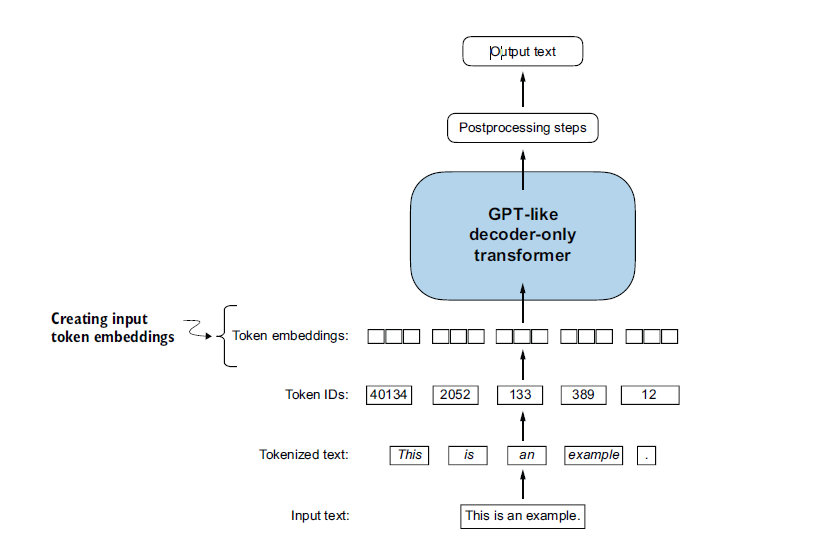

</div>


As a preliminary step, we must initialize
these embedding weights with random values. This initialization serves as the starting
point for the LLM’s learning process. In chapter 5, we will optimize the embedding
weights as part of the LLM training.
A continuous vector representation, or embedding, is necessary since GPT-like
LLMs are deep neural networks trained with the backpropagation algorithm.

For the sake of simplicity, suppose we have a small vocabulary of only 6 words (instead
of the 50,257 words in the BPE tokenizer vocabulary), and we want to create embeddings
of size 3 (in GPT-3, the embedding size is 12,288 dimensions):

In [4]:
import torch
import torch.nn as nn

# Define vocabulary size and output (embedding) dimension
vocab_size = 6  # The size of the vocabulary (number of unique tokens)
out_dim = 3     # The dimensionality of each token embedding

# Set a random seed for reproducibility
torch.manual_seed(123)

# Create an instance of the nn.Embedding class
token_emb = nn.Embedding(vocab_size, out_dim)

# Print the weights of the token embedding layer
print(token_emb.weight) # ----> this will be trained later in LLM training

# Summary
# In other words, the embedding layer is essentially a lookup operation that retrieves rows from the embedding layer’s weight matrix via a token ID.
# we can consider this operation to be an effience one-hot encoding (in you are familiar with the conceopt)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


## 2- Positional Encoding

### What is Positional Encoding?

In natural language processing and sequence modeling, the order of tokens (words, subwords, etc.) in a sequence is crucial for understanding the context and relationships between them. Unlike recurrent neural networks (RNNs), which inherently process sequences in order, transformer architectures process all tokens simultaneously. This parallel processing can lead to a loss of positional information if not addressed properly.

To solve this issue, **positional encoding** is introduced. Positional encoding is a technique used to provide information about the relative or absolute position of tokens in a sequence. It is added to the input embeddings (token embeddings) to ensure that the model can differentiate between tokens based on their positions.

### Why is Positional Encoding Important?

1. **Capturing Token Order**: Positional encoding helps the model learn the sequence of tokens. Without it, the model would treat the input as a bag of tokens, disregarding their order, which is essential for tasks like language modeling, translation, and text generation.

2. **Enhancing Contextual Understanding**: By encoding positions, the model can better understand how different tokens relate to each other based on their positions in the sequence. For example, in the sentence "The cat sat on the mat," knowing the positions of "cat" and "sat" allows the model to understand the grammatical structure and meaning.

3. **Facilitating Attention Mechanisms**: Transformers rely on attention mechanisms to weigh the significance of different tokens. Positional encodings help the attention layers focus on the correct tokens based on their positions, improving the model's ability to capture long-range dependencies in the input sequence.

### Types of Positional Encoding

There are various methods to encode positions, with the two most common being:

- **Learned Positional Embeddings**: This approach uses an embedding layer to learn a unique positional vector for each position in the sequence. This method allows the model to optimize the positional information during training. (this what we will use)

- **Sinusoidal Positional Encoding**: Introduced in the original transformer paper, this method uses sine and cosine functions to create positional encodings based on the position of tokens. It provides a fixed, continuous representation of positions and allows the model to generalize to sequences longer than those seen during training.

In summary, positional encoding is a critical component in transformer architectures, enabling them to effectively process sequential data while preserving the essential order of tokens.


In [5]:
# Define the maximum sequence length and embedding dimension
max_seq_length = 10  # Maximum length of the input sequences
out_dim = 3          # The dimensionality of each positional embedding

# Set a random seed for reproducibility
torch.manual_seed(123)

# Create a positional embedding matrix
pos_emb = nn.Embedding(max_seq_length, out_dim)

# Create a tensor representing positions
positions = torch.arange(max_seq_length).unsqueeze(1)  # Shape: (max_seq_length, 1)

# Get the positional embeddings for the given positions
positional_embeddings = pos_emb(positions)

# Print the weights of the positional embedding layer and the positional embeddings
print("Positional Embedding Weights:")
print(pos_emb.weight)
print("\nPositional Embeddings for Each Position:")
print(positional_embeddings)


Positional Embedding Weights:
Parameter containing:
tensor([[ 0.3374, -0.1778, -0.3035],
        [-0.5880,  0.3486,  0.6603],
        [-0.2196, -0.3792,  0.7671],
        [-1.1925,  0.6984, -1.4097],
        [ 0.1794,  1.8951,  1.3689],
        [-1.6033, -1.3250,  0.1784],
        [-2.1338,  1.0524, -0.3885],
        [-0.9343,  1.8319, -0.3378],
        [ 0.8805,  1.5542,  0.6266],
        [-0.1755,  0.0983, -0.0935]], requires_grad=True)

Positional Embeddings for Each Position:
tensor([[[ 0.3374, -0.1778, -0.3035]],

        [[-0.5880,  0.3486,  0.6603]],

        [[-0.2196, -0.3792,  0.7671]],

        [[-1.1925,  0.6984, -1.4097]],

        [[ 0.1794,  1.8951,  1.3689]],

        [[-1.6033, -1.3250,  0.1784]],

        [[-2.1338,  1.0524, -0.3885]],

        [[-0.9343,  1.8319, -0.3378]],

        [[ 0.8805,  1.5542,  0.6266]],

        [[-0.1755,  0.0983, -0.0935]]], grad_fn=<EmbeddingBackward0>)


## The Input Embedding Pipeline

In GPT models, the input embedding pipeline combines **token embeddings** and **positional embeddings** to prepare input data.

We create the final embedding by adding the token embeddings and positional embeddings together:

\[
\text{embedding} = \text{token embedding} + \text{positional embedding}
\]

This combined embedding contains both the semantic meaning and the positional context of the tokens, enabling the GPT model to effectively process the input sequence.

<div align="center">

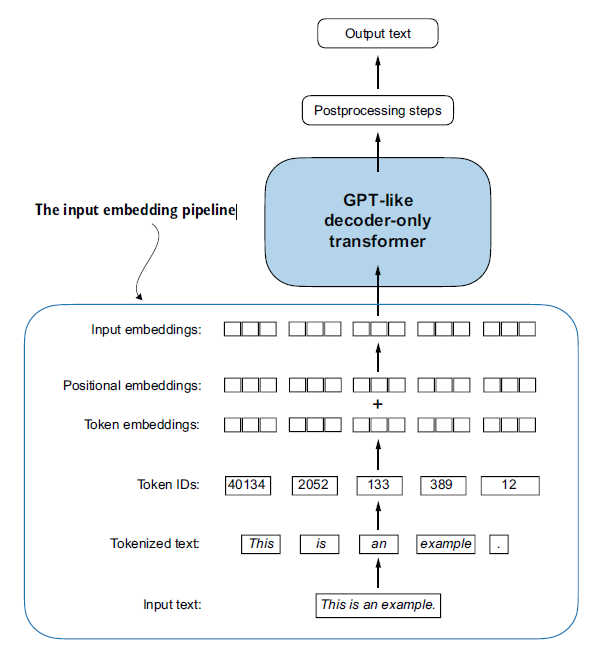

</div>


### 3-Transformer Block Components

In a transformer architecture, each transformer block consists of several key components:

A. **Layer Normalization**:
   - Normalizes the input across features to stabilize and accelerate training.

B. **Dropout**:(notebook 2)
   - Introduces randomness during training to prevent overfitting by randomly setting a fraction of the input units to zero.

C. **Multi-Head Attention**:(notebook 2)
   - Allows the model to focus on different parts of the input sequence simultaneously, capturing relationships effectively.

D. **Feedforward Neural Network (FNN)**:
   - Further transforms the output of the attention mechanism using linear transformations and non-linear activation functions.

E. **Shortcut Connections**:
   - Also known as residual connections, these allow the input to bypass the current layer and be added back into the output, helping to mitigate the vanishing gradient problem and improve gradient flow during training.

## A. Normalizing activations with layer normalization
Training deep neural networks with many layers can sometimes prove challenging
due to problems like vanishing or exploding gradients. These problems lead to unstable
training dynamics and make it difficult for the network to effectively adjust its
weights, which means the learning process struggles to find a set of parameters
(weights) for the neural network that minimizes the loss function. In other words, the
network has difficulty learning the underlying patterns in the data to a degree that
would allow it to make accurate predictions or decisions.

<p align="center">
    <img src="layer_norm.PNG" alt="Layer Normalization">
</p>


In [6]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super(LayerNorm, self).__init__()  # Proper use of super
        self.scale = nn.Parameter(torch.ones(emb_dim))  # Learnable scale parameter
        self.shift = nn.Parameter(torch.zeros(emb_dim))  # Learnable shift parameter (should be zeros for proper centering)
        self.eps = 1e-5  # Small epsilon to avoid division by zero

    def forward(self, x):
        # Calculate the mean and variance across the last dimension (features)
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)  # Corrected 'unbiased' argument
        
        # Normalize the input using the mean and variance
        normalized_x = (x - mean) / torch.sqrt(var + self.eps)
        
        # Apply learnable scale and shift
        return self.scale * normalized_x + self.shift


pytorch offer out of the box impleenation of layer norm lets compare the two 

In [7]:
# Set the embedding dimension
emb_dim = 5

# Create random input tensor (batch_size=3, emb_dim=5)
torch.manual_seed(42)
x = torch.randn(3, emb_dim)

# Initialize custom LayerNorm and PyTorch's built-in LayerNorm
custom_layer_norm = LayerNorm(emb_dim)
torch_layer_norm = nn.LayerNorm(emb_dim)

# Get output from both implementations
custom_output = custom_layer_norm(x)
torch_output = torch_layer_norm(x)

# Print both results for comparison
print("Custom LayerNorm Output:\n", custom_output)
print("\nPyTorch LayerNorm Output:\n", torch_output)

# Check the difference between both results
difference = torch.abs(custom_output - torch_output)
print("\nDifference between Custom and PyTorch LayerNorm:\n", difference)

Custom LayerNorm Output:
 tensor([[ 0.6870,  0.3064,  0.4998,  0.4923, -1.9854],
        [-0.6274,  1.8398, -1.0928,  0.0403, -0.1599],
        [ 0.5293,  0.7799,  1.0547, -1.5020, -0.8620]], grad_fn=<AddBackward0>)

PyTorch LayerNorm Output:
 tensor([[ 0.6870,  0.3064,  0.4998,  0.4923, -1.9854],
        [-0.6274,  1.8398, -1.0928,  0.0403, -0.1599],
        [ 0.5293,  0.7799,  1.0547, -1.5020, -0.8620]],
       grad_fn=<NativeLayerNormBackward0>)

Difference between Custom and PyTorch LayerNorm:
 tensor([[1.1921e-07, 2.9802e-08, 5.9605e-08, 5.9605e-08, 2.3842e-07],
        [5.9605e-08, 3.5763e-07, 0.0000e+00, 6.7055e-08, 4.4703e-08],
        [0.0000e+00, 5.9605e-08, 0.0000e+00, 0.0000e+00, 5.9605e-08]],
       grad_fn=<AbsBackward0>)


## 4.Implementing a feed forward network & GELU activations function
## 4. Implementing a Feed Forward Network & GELU Activation Function

In the transformer architecture, after the multi-head attention mechanism, we apply a feed forward network (FFN) to each position of the sequence independently. This FFN is essentially a two-layer neural network, which is crucial for introducing non-linearity and transforming the attention output.

### Key Components:
1. **Feed Forward Network (FFN)**: This consists of two linear transformations with a non-linear activation function in between. Typically, the dimensions are expanded in the first linear layer (projection to a higher dimension) and then reduced back to the original size in the second layer.
   
2. **GELU (Gaussian Error Linear Unit)**: Instead of using ReLU, many modern transformer models like GPT use the GELU activation function. GELU introduces smoothness in activations and is defined as:
   
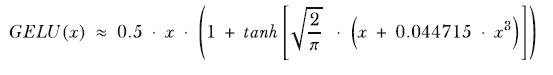

If it's still not rendering properly, you can ensure that the platform you're using supports LaTeX by checking its documentation, or alternatively, try running the code in a different environment, like Jupyter Notebook, which typically supports LaTeX in Markdown.



Unlike ReLU, which harshly zeroes out negative values, GELU weights inputs depending on how far they are from zero, providing a smoother gradient flow during training.



In [8]:
# the idea in the two linear layers are clear (a projection to higer dims)
# so lets implement the GELU activation function from scratch for deeper understanding 
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

Again pytorch offer out the box immplementaion of the GELU , lets comapre them through plotting 

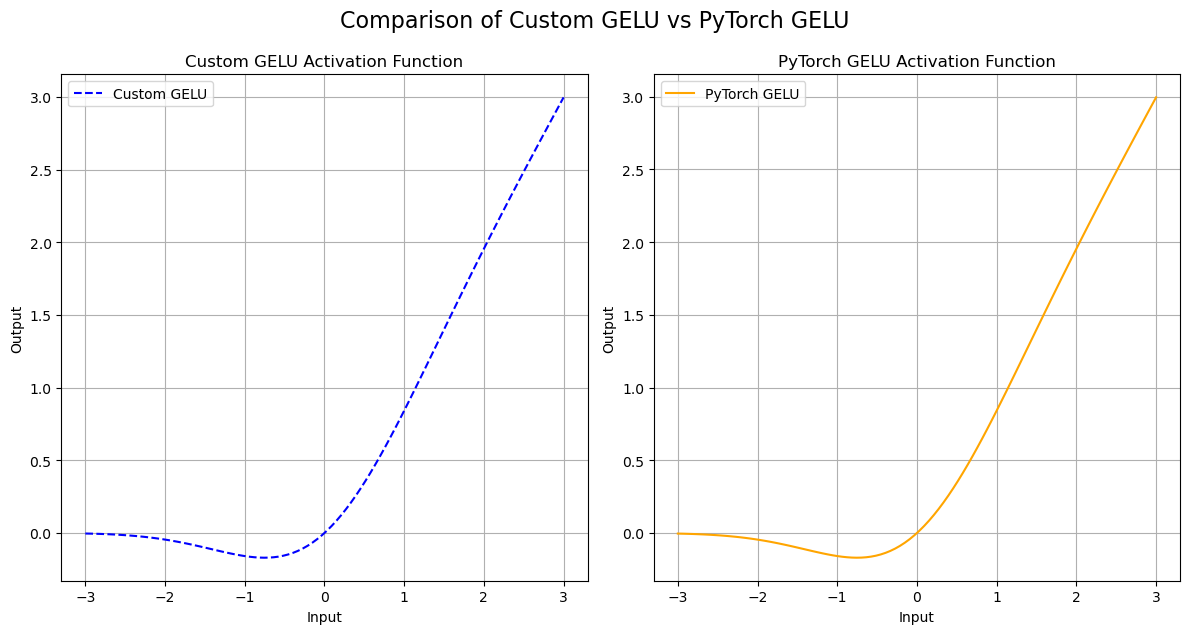

In [9]:
import matplotlib.pyplot as plt 


# PyTorch's built-in GELU
pytorch_gelu = nn.GELU()

# Instantiate the custom GELU
custom_gelu = GELU()

# Generate random input values
x = torch.linspace(-3, 3, 100)

# Compute outputs
custom_gelu_output = custom_gelu(x)
pytorch_gelu_output = pytorch_gelu(x)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the Custom GELU
axs[0].plot(x.detach().numpy(), custom_gelu_output.detach().numpy(), label='Custom GELU', linestyle='--', color='blue')
axs[0].set_title('Custom GELU Activation Function')
axs[0].set_xlabel('Input')
axs[0].set_ylabel('Output')
axs[0].legend()
axs[0].grid(True)

# Plotting the PyTorch GELU
axs[1].plot(x.detach().numpy(), pytorch_gelu_output.detach().numpy(), label='PyTorch GELU', linestyle='-', color='orange')
axs[1].set_title('PyTorch GELU Activation Function')
axs[1].set_xlabel('Input')
axs[1].set_ylabel('Output')
axs[1].legend()
axs[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.suptitle('Comparison of Custom GELU vs PyTorch GELU', fontsize=16, y=1.05)
plt.show()


Comparing RELU and GELU 

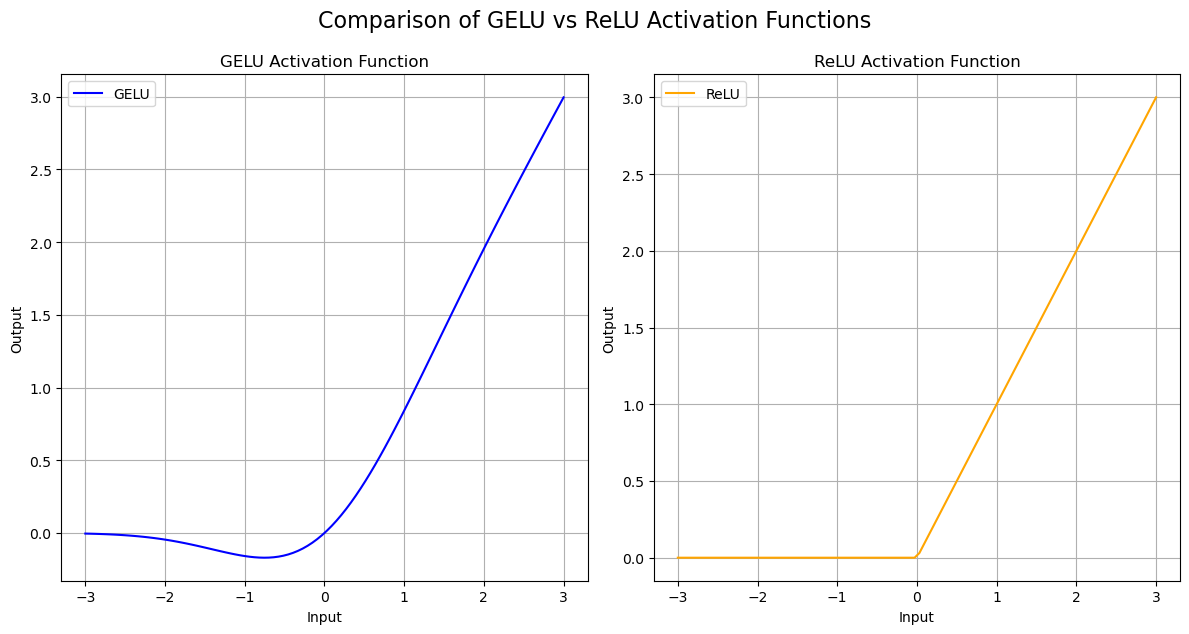

In [10]:

relu = nn.ReLU()
relu_output = relu(x)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the GELU
axs[0].plot(x.detach().numpy(), pytorch_gelu_output.detach().numpy(), label='GELU', linestyle='-', color='blue')
axs[0].set_title('GELU Activation Function')
axs[0].set_xlabel('Input')
axs[0].set_ylabel('Output')
axs[0].legend()
axs[0].grid(True)

# Plotting the ReLU
axs[1].plot(x.detach().numpy(), relu_output.detach().numpy(), label='ReLU', linestyle='-', color='orange')
axs[1].set_title('ReLU Activation Function')
axs[1].set_xlabel('Input')
axs[1].set_ylabel('Output')
axs[1].legend()
axs[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.suptitle('Comparison of GELU vs ReLU Activation Functions', fontsize=16, y=1.05)
plt.show()

In [11]:
# Define the FeedForward neural network class
class FeedForward(nn.Module):
    def __init__(self, config):
        # Call the parent class constructor
        super().__init__()

        # Define a sequential model with two linear layers and a GELU activation function
        self.layers = nn.Sequential(
            # First linear layer: projects input from 'emb_dim' to '4 * emb_dim'
            nn.Linear(config['emb_dim'], 4 * config['emb_dim']),
            # GELU activation function applied after the first linear layer
            nn.GELU(),
            # Second linear layer: projects input from '4 * emb_dim' back to 'emb_dim'
            nn.Linear(4 * config['emb_dim'], config['emb_dim'])
        )

    def forward(self, x):
        # Forward pass: apply the sequential layers to the input x
        return self.layers(x)


# 4.Adding shortcut connections

<div style="text-align: center;">
    <img src="skip.PNG" alt="Skip Connections">
</div>

Let’s discuss the concept behind shortcut connections, also known as skip or residual
connections. Originally, shortcut connections were proposed for deep networks in
computer vision (specifically, in residual networks) to mitigate the challenge of vanishing
gradients. The vanishing gradient problem refers to the issue where gradients
(which guide weight updates during training) become progressively smaller as they
propagate backward through the layers, making it difficult to effectively train earlier
layers.

<div style="text-align: center;">
    <img src="res-no-res.PNG" alt="Result with and without Residual Connections">
</div>

the figure above A comparison between a deep neural network consisting of five layers without (left) and with
shortcut connections (right). Shortcut connections involve adding the inputs of a layer to its outputs, effectively
creating an alternate path that bypasses certain layers. The gradients denote the mean absolute gradient at each
layer,

In [12]:
# implementing the skip connection is fairly easy in pytorch  

# Set the dimensions for the input and output
input_dim = 4
output_dim = 4

# Create a linear layer to transform the input
linear_layer = nn.Linear(input_dim, output_dim)

# Create a random input tensor
x = torch.rand(2, input_dim)  # Batch size of 2

# Pass the input through the linear layer
transformed_x = linear_layer(x)

# Add the input to the transformed output (skip connection)
output = transformed_x + x  # Skip connection

# Print the results
print("Input:\n", x)
print("Transformed Output:\n", transformed_x)
print("Output with Skip Connection:\n", output)


Input:
 tensor([[0.1165, 0.9103, 0.6440, 0.7071],
        [0.6581, 0.4913, 0.8913, 0.1447]])
Transformed Output:
 tensor([[ 0.4885, -0.0042, -0.1515, -0.1093],
        [ 0.4489, -0.0291, -0.2210,  0.1599]], grad_fn=<AddmmBackward0>)
Output with Skip Connection:
 tensor([[0.6050, 0.9060, 0.4925, 0.5978],
        [1.1070, 0.4622, 0.6703, 0.3046]], grad_fn=<AddBackward0>)


In [13]:
# now we have it all to implment the transformer block 
# dont forget out MultiHeadAttention implementaion from the previous notebook 

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in,d_out, context_length, dropout, num_heads, bias=False):
          
        super().__init__()
        assert (d_out % num_heads == 0) 
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=bias)
        self.W_key = nn.Linear(d_in, d_out, bias=bias)
        self.W_value = nn.Linear(d_in, d_out, bias=bias)
        self.dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(d_out, d_out)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length),diagonal=1))

    def forward(self, x):
        b , num_tokens, d_in = x.shape
        keys = self.W_key(x)
        values = self.W_value(x)
        qurey = self.W_query(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        qurey = qurey.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1,2)
        values = values.transpose(1,2)
        qurey = qurey.transpose(1,2)

        attention_score = qurey @ keys.transpose(2,3)
        mask_bool = self.mask[:num_tokens, :num_tokens].bool()
        attention_score.masked_fill_(mask_bool, -torch.inf) 

        attention_weight = torch.softmax(attention_score / keys.shape[-1] ** 0.5, dim=-1)
        attention_weight = self.dropout(attention_weight)

        all_con_vec = (attention_weight @ values).transpose(1,2)
        all_con_vec = all_con_vec.contiguous().view(b, num_tokens, self.d_out)

        output = self.proj(all_con_vec)
        return output


In [14]:
# now lets implement the transformer block 
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        # Initialize the multi-head attention layer
        self.attention = MultiHeadAttention(
            d_in=config["emb_dim"],              # Input dimension
            d_out=config["emb_dim"],             # Output dimension
            context_length=config["context_length"],  # Length of the context
            dropout=config["dropout"],            # Dropout rate
            num_heads=config["n_head"],           # Number of attention heads
            bias=config["qkv_bias"]               # Whether to include bias in Q, K, V
        )
        
        # Initialize the feedforward layer
        self.feedforward = FeedForward(config)    # Assuming FeedForward is defined elsewhere

        # Initialize layer normalization layers
        self.norm1 = nn.LayerNorm(config["emb_dim"])  # First normalization layer
        self.norm2 = nn.LayerNorm(config["emb_dim"])  # Second normalization layer
        
        # Initialize dropout layer
        self.dropout = nn.Dropout(config["dropout"])  # Dropout layer for regularization

    def forward(self, x):
        # Save the original input for skip connection
        shortcut = x
        
        # Apply first layer normalization
        x = self.norm1(x)
        
        # Apply multi-head attention
        x = self.attention(x)
        
        # Apply dropout after attention
        x = self.dropout(x)
        
        # Add the skip connection (shortcut) from the original input
        x = shortcut + x

        # Save the output for the next skip connection
        shortcut = x
        
        # Apply second layer normalization
        x = self.norm2(x)
        
        # Apply feedforward layer
        x = self.feedforward(x)
        
        # Apply dropout after feedforward
        x = self.dropout(x)
        
        # Add the skip connection (shortcut) again
        x = shortcut + x
        
        return x  # Return the output of the transformer block


In [15]:
# Initialize the configuration for GPT
GPT_CONFIG_124 = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_head": 12,
    "n_layer": 12,
    "dropout": 0.1,
    "qkv_bias": False,
}

# Create an instance of the TransformerBlock
transformer_block = TransformerBlock(GPT_CONFIG_124)

# Create a sample input tensor
# Assuming a batch size of 2 and the embedding dimension matches GPT_CONFIG_124
sample_input = torch.randn(2, 10, GPT_CONFIG_124['emb_dim'])  # (batch_size, sequence_length, emb_dim)

# Pass the sample input through the transformer block
output = transformer_block(sample_input)

# Print the shape of the output
print("Output shape:", output.shape)  # Expected shape: (batch_size, sequence_length, emb_dim)

Output shape: torch.Size([2, 10, 768])


# After setting up all the building blocks we ready to code the GPT class
<div align="center">
    <img src="gpt_blocks.PNG" alt="GPT Blocks" />
</div>


# Building GPT-2 Small (124M) Using Transformer Blocks

The **Generative Pre-trained Transformer (GPT)** is a state-of-the-art architecture for natural language processing tasks. In this implementation, we will build the **GPT-2 Small** model, which contains 124 million parameters. This model is known for its ability to generate coherent and contextually relevant text across a wide range of topics.

## Key Components of GPT-2

1. **Transformer Block**: At the core of GPT-2 are multiple layers of Transformer Blocks. Each block consists of:
   - **Multi-Head Attention**: This component allows the model to focus on different parts of the input sequence simultaneously, capturing various aspects of the data.
   - **Feedforward Network**: A series of linear transformations with non-linear activation functions, further processing the output from the attention layer.
   - **Layer Normalization**: Normalizes the outputs to stabilize and accelerate training.
   - **Residual Connections**: These connections help preserve information from previous layers, facilitating better gradient flow during training.

2. **Positional Encoding**: Since transformers lack a sense of sequential order, we will incorporate positional encodings to give the model information about the order of the tokens.

3. **Embedding Layer**: The input tokens will be transformed into dense vectors (embeddings) that the model can process.

4. **Output Layer**: The final layer will produce logits for each token in the vocabulary, allowing us to compute probabilities for the next word during text generation.

## GPT-2 Small Configuration

We will implement GPT-2 Small with the following configuration:

```python
GPT_CONFIG_124 = {
    "vocab_size": 50257,      # Size of the vocabulary
    "context_length": 1024,   # Maximum length of the input context
    "emb_dim": 768,           # Dimension of the embeddings
    "n_head": 12,             # Number of attention heads
    "n_layer": 12,            # Number of transformer layers
    "dropout": 0.1,           # Dropout rate for regularization
    "qkv_bias": False,        # Whether to include bias in Q, K, V projections
}
```

## Building GPT-2 with Transformer Blocks

In this implementation, we will build the GPT-2 architecture by stacking multiple **Transformer Blocks** based on the above configuration. Each block will process the input representations sequentially, allowing the model to learn complex relationships in the data.


In [16]:
class GPTModel(nn.Module):
    def __init__(self, config):
        super(GPTModel, self).__init__()

        # Token embedding layer: maps input tokens to embeddings
        self.token_embedding = nn.Embedding(config['vocab_size'], config['emb_dim'])

        # Positional embedding layer: adds positional information to embeddings
        self.position_embedding = nn.Embedding(config['context_length'], config['emb_dim'])

        # Dropout layer for regularization
        self.dropout = nn.Dropout(config['dropout'])

        # Stack of transformer blocks: creates a sequential list of TransformerBlock instances
        self.trans_blk = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config['n_layer'])]
        )

        # Layer normalization to stabilize and accelerate training
        self.layerNorm = nn.LayerNorm(config['emb_dim'])

        # Output layer: projects the output to the size of the vocabulary for next token prediction
        self.output = nn.Linear(config['emb_dim'], config['vocab_size'])

    def forward(self, x):
        # x: input tensor of shape (batch_size, sequence_length)

        # Get token embeddings for the input tokens
        token_embeddings = self.token_embedding(x)  # Shape: (batch_size, sequence_length, emb_dim)

        # Create positional indices for the input sequence length
        position_indices = torch.arange(x.size(1), device=x.device).unsqueeze(0)  # Shape: (1, sequence_length)

        # Get positional embeddings and add them to token embeddings
        position_embeddings = self.position_embedding(position_indices)  # Shape: (1, sequence_length, emb_dim)
        embeddings = token_embeddings + position_embeddings  # Element-wise addition

        # Apply dropout to the combined embeddings
        embeddings = self.dropout(embeddings)

        # Pass the embeddings through the transformer blocks
        transformer_output = self.trans_blk(embeddings)  # Shape: (batch_size, sequence_length, emb_dim)

        # Apply layer normalization to the output of the transformer blocks
        normalized_output = self.layerNorm(transformer_output)

        # Project the normalized output to the vocabulary size
        logits = self.output(normalized_output)  # Shape: (batch_size, sequence_length, vocab_size)

        return logits


# Initializing the GPT-2 Small Model

In this section, we will initialize the GPT-2 Small model (124M parameters) and take a closer look at its architecture.

## Model Configuration

The configuration for the GPT-2 Small model is defined as follows:

- **vocab_size**: 50257  
  The size of the vocabulary, indicating the number of unique tokens the model can recognize.

- **context_length**: 1024  
  The maximum length of input sequences that the model can process.

- **emb_dim**: 768  
  The dimensionality of the embeddings, which determines the size of the representation for each token.

- **n_head**: 12  
  The number of attention heads used in the multi-head attention mechanism. More heads allow the model to focus on different parts of the input.

- **n_layer**: 12  
  The number of transformer blocks (layers) in the model. Each block contains multi-head attention and feedforward components.

- **dropout**: 0.1  
  The dropout rate applied during training to prevent overfitting.

- **qkv_bias**: False  
  A boolean indicating whether to use bias terms in the


In [17]:
# Create an instance of the GPTModel
gpt_model = GPTModel(GPT_CONFIG_124)

# Create a sample input tensor of shape (batch_size, sequence_length)
# Here, we use a batch size of 2 and a sequence length of 10 (you can adjust as needed)
batch_size = 2
sequence_length = 10
sample_input = torch.randint(0, GPT_CONFIG_124['vocab_size'], (batch_size, sequence_length))

# Pass the sample input through the model to get the output logits
output_logits = gpt_model(sample_input)

# Print the output logits shape and the model architecture
print("Output logits shape:", output_logits.shape)  # Should be (batch_size, sequence_length, vocab_size)
print("\nModel Architecture:\n", gpt_model)

Output logits shape: torch.Size([2, 10, 50257])

Model Architecture:
 GPTModel(
  (token_embedding): Embedding(50257, 768)
  (position_embedding): Embedding(1024, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (trans_blk): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (feedforward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm

# Flexibility to Create GPT-2 Variants

One of the advantages of our implementation is that we can easily produce different variants of the GPT-2 model, including the larger 335M and XL (1.5B) versions, simply by adjusting the configuration parameters. This flexibility allows us to experiment with different model sizes and configurations without needing to modify the underlying code structure.

## Configurations for GPT-2 Variants

Here are example configurations for the GPT-2 variants:

### GPT-2 Medium (335M)

```python
GPT_CONFIG_335 = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 1024,        # Increased embedding dimension
    "n_head": 16,           # More attention heads
    "n_layer": 24,          # More transformer blocks
    "dropout": 0.1,
    "qkv_bias": False,
}
```

### GPT-2 XL (1.5B)

```python
GPT_CONFIG_XL = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 1600,        # Larger embedding dimension
    "n_head": 20,           # More attention heads
    "n_layer": 48,          # More transformer blocks
    "dropout": 0.1,
    "qkv_bias": False,
}
```


In [19]:

GPT_CONFIG_335 = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 1024,        # Increased embedding dimension
    "n_head": 16,           # More attention heads
    "n_layer": 24,          # More transformer blocks
    "dropout": 0.1,
    "qkv_bias": False,
}

# Initialize the GPT-2 Medium model
gpt_medium_model = GPTModel(GPT_CONFIG_335)

# Print the architectures
print("GPT-2 Medium Model Architecture:")
print(gpt_medium_model)



GPT-2 Medium Model Architecture:
GPTModel(
  (token_embedding): Embedding(50257, 1024)
  (position_embedding): Embedding(1024, 1024)
  (dropout): Dropout(p=0.1, inplace=False)
  (trans_blk): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=False)
        (W_key): Linear(in_features=1024, out_features=1024, bias=False)
        (W_value): Linear(in_features=1024, out_features=1024, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (feedforward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((1024,), eps=1e-05, ele

# 🎉 Celebration of Completion! 🎉

Congratulations! You've successfully built a foundational implementation of the GPT-2 architecture using Transformer blocks. This notebook has guided you through the essential components of the model, from multi-head attention to feedforward layers, culminating in the creation of a fully functional GPT model.

## What's Next? 🚀

In the upcoming notebook, we will take the following exciting steps:

1. **Loading Pretrained Weights**: We'll explore how to load pretrained weights into our GPT model, allowing us to leverage existing knowledge and enhance our model's performance on various tasks.

2. **Generating Output**: You'll learn how to use the model to generate text based on input prompts, showcasing the power of GPT-2 in natural language generation.

3. **Designing a Simple UI App**: To make our model accessible, we'll design a simple user interface application that allows users to interact with the model and generate text seamlessly.

By the end of the next notebook, you'll have a complete workflow from building the model to using it in a user-friendly application. Stay tuned for more exciting explorations in the world of GPT models!

Happy coding! 🎊
